# Electrisity Output and Wind Speed Model 

## Regression Model

## Data exploration


             DATETIME  CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
0 2020-01-09 00:00:00 NaN        1.69        1.88        3.15        0.92   
1 2020-01-09 01:00:00 NaN        1.60        2.02        3.91        0.44   
2 2020-01-09 02:00:00 NaN        1.79        2.14        4.20        0.65   
3 2020-01-09 03:00:00 NaN        2.01        2.32        5.17        0.51   
4 2020-01-09 04:00:00 NaN        2.12        2.54        4.19        0.77   

   WS_1193865  WS_1321569  WS_1324653  WS_1358699  ...  WS_78208  WS_811655  \
0        2.27        1.14        1.24        2.98  ...      1.40       1.27   
1        2.36        1.15        1.63        2.83  ...      1.02       1.11   
2        2.06        1.28        2.36        3.07  ...      1.39       1.42   
3        2.31        0.83        3.39        3.38  ...      1.55       2.01   
4        4.52        0.97        2.89        3.79  ...      1.64       2.40   

   WS_839753  WS_875373  WS_883683  WS_883699  WS_914573  WS_9

<AxesSubplot:>

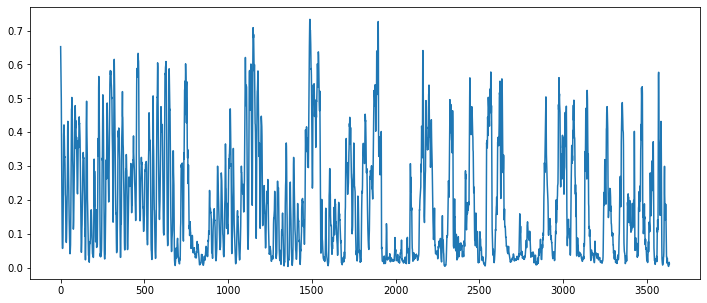

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Analysis
df = pd.read_excel('Wind_data.xlsx', sheet_name=[0, 1])
# df = pd.read_excel('Wind_data.xlsx', index_col='DATETIME', sheet_name=[0, 1])
df_train, df_test = df.get(0), df.get(1)

print(df_test.head())
print(df_test.info())
print(df_test.describe())
print(df_train.isnull().values.any())
print(df_test.isnull().any(axis=1).sum())
print(df_test.isnull().any(axis=0).sum())
df_train = df_train.dropna()
df_train['CF'].plot(figsize=(12,5))

## Feature Engineering: Identify significant variables

<AxesSubplot:>

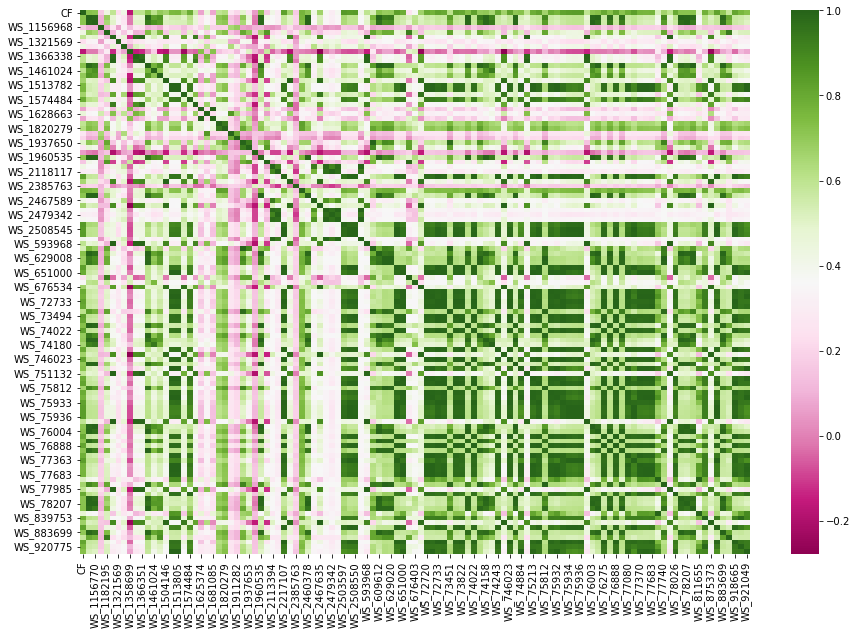

In [2]:
# Compute correlation between variables and target
# In this correlation map, light color means lower covariance of two variables.
# We can not manually decide which features are salent, it looks like most of the features are relavant. 
# As a result, some numeriacal feature selection algorithms can be adopted.

import seaborn as sns
data = df_train
data.corr(method='pearson')
plt.subplots(figsize=(15, 10))
sns.heatmap(data.corr(), cmap="PiYG")

### Naive Linear Regression Model without Feature Engineering

      WS_1133733  WS_1156770  WS_1156968  WS_1182195  WS_1193865  WS_1321569  \
3110        1.78        1.49        2.00        5.27        2.13        1.24   
1808        5.11        3.89       10.98        4.19        8.28        2.24   
1596        3.44        2.61        1.80        1.80        2.24        0.63   
672         5.58        5.41        5.00        3.61        9.28        1.85   
2011        3.66        3.22        2.36        6.43        1.68        1.78   

      WS_1324653  WS_1358699  WS_1366338  WS_1366351  ...  WS_875373  \
3110        1.76        4.88        1.77        2.30  ...       1.71   
1808        8.13        0.78        9.94        7.36  ...       7.14   
1596        1.71        0.82        2.22        2.23  ...       1.13   
672         5.91        1.04       10.17        8.87  ...       8.84   
2011        1.66        2.23        1.62        1.62  ...       1.88   

      WS_883683  WS_883699  WS_914573  WS_918665  WS_920775  WS_921049  hour  \
3110  

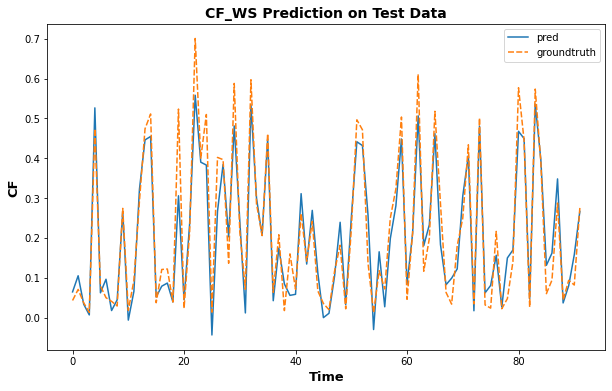

In [21]:
# shuffle data samples
# df_train = df_train.sample(frac = 1)

# extract hour, day, month feature
df_train['hour'] = df_train['DATETIME'].dt.hour
df_train['month'] = df_train['DATETIME'].dt.month
df_train['day'] = df_train['DATETIME'].dt.day

# split dataset
Y = df_train[['CF']]
# X = df_train.set_index('DATETIME')
X = df_train.drop(['DATETIME','CF'], axis=1)
print(X.head())
# X = df_train.drop(['CF'], axis=1)
x_train, x_val,y_train, y_val = X[:-92], X[-92:], Y[:-92], Y[-92:]
x, y, x_val,y_val = x_train.values, y_train.values, x_val.values, y_val.values


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

mlr = LinearRegression()
sc_x = StandardScaler()

# scale and normalize training data
X_new = sc_x.fit_transform(x)

# model fitting
mlr.fit(X_new, y)

# prediction
X_val_new = sc_x.transform(x_val)
y_hat = mlr.predict(X_val_new)
print(f'Training accu: {mlr.score(X_new, y)}')
print(f'Test accu: {mlr.score(X_val_new, y_val)}')
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["pred", "groundtruth"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE: {mae:.3f}')

### Naive Linear Regression Model without Feature Engineering(shuffle train and val data)

#### data shuffle improved the result by 0.002 for linear regression

Training accu: 0.8920872401975677
Test accu: 0.9058572894448861
validation data MAE from sklearn mae metrics: 0.044
validation data MAE: 0.044


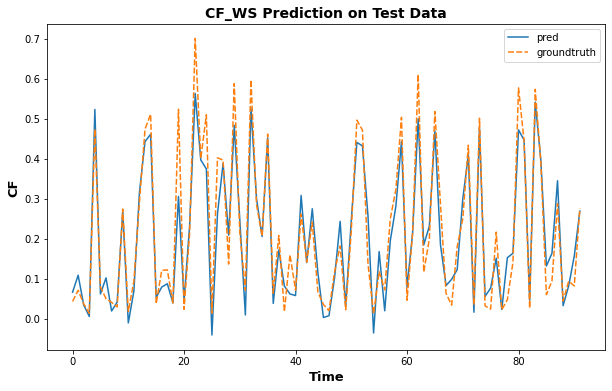

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# shuffle data samples
df_train = df_train.sample(frac = 1)

# split dataset
Y = df_train[['CF']]
X = df_train.drop(['DATETIME','CF'], axis=1)

x_train, x_val,y_train, y_val = X[:-92], X[-92:], Y[:-92], Y[-92:]
x, y, x_val,y_val = x_train.values, y_train.values, x_val.values, y_val.values


mlr = LinearRegression()
sc_x = StandardScaler()

# scale and normalize training data
X_new = sc_x.fit_transform(x)

# model fitting
mlr.fit(X_new, y)

# prediction
X_val_new = sc_x.transform(x_val)
y_hat = mlr.predict(X_val_new)
print(f'Training accu: {mlr.score(X_new, y)}')
print(f'Test accu: {mlr.score(X_val_new, y_val)}')
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["pred", "groundtruth"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE: {mae:.3f}')

### Engineer new features to improve the results
#### The above linear regression method sometimes are too simple so that can not fit complex functions.
#### Hence I introducced PolynomialFeatures to project data into high dimension space to better fit the curve.
#### In addition, I introduced L1/L2 regularization to further boost the results.
#### Naively adopting PolynomialFeatures leads to overfitting since 1) there's too many features here(115), it's very easy to get overfitting. 2) Polynomial Features in high dimensional space might also lead to overfitting. Hence I introducce L2 and L1 norm to supress overfitting.

Training accu: 1.0
Test accu: 0.47056777297039665
validation data MAE from sklearn mae metrics: 0.083
validation data MAE: 0.083


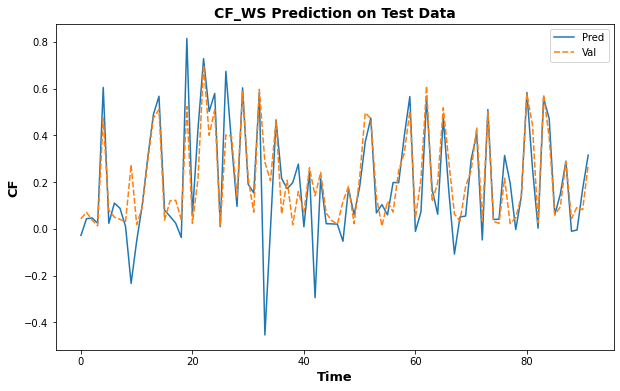

In [9]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# model define
mlr = LinearRegression()
sc_x = StandardScaler()



steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)
pipeline.fit(x, y)
print(f'Training accu: {pipeline.score(x, y)}')
print(f'Test accu: {pipeline.score(x_val, y_val)}')

# prediction

y_hat = pipeline.predict(x_val)

mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["Pred", "Val"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE: {mae:.3f}')

#### PolynomialFeatures + L2 regularization improved the results by a large margin

Training accu: 0.9764766386638374
Test accu: 0.9496473794358651
validation data MAE from sklearn mae metrics: 0.028
validation data MAE: 0.028


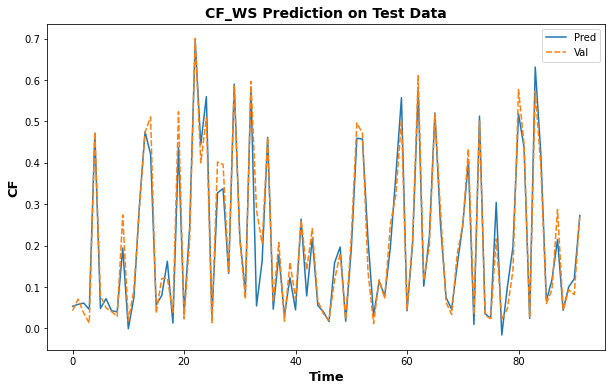

In [10]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

##  model define
# linear regression with L2 norm

## Engineer new features to improve the results


# note that degree=3 for PolynomialFeatures provides even better results(increased by 0.005) but it takes much longer time to run.

steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=10, fit_intercept=True))
]

pipeline = Pipeline(steps)
pipeline.fit(x, y)
print(f'Training accu: {pipeline.score(x, y)}')
print(f'Test accu: {pipeline.score(x_val, y_val)}')

# prediction

y_hat = pipeline.predict(x_val)

mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["Pred", "Val"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE: {mae:.3f}')

#### PolynomialFeatures + L1 Regularization

/Users/steven/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.060e+00, tolerance: 9.576e-03
  model = cd_fast.enet_coordinate_descent(


Training accu: 0.9771084318759314
Test accu: 0.9538196126751126
(92, 1)
(92, 1)
validation data MAE from sklearn mae metrics: 0.029
validation data MAE: 0.029


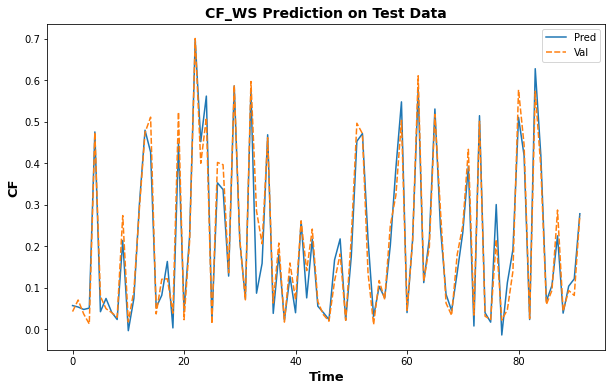

In [12]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# engineer new features to improve the results
# since 1) there's too many features here(112), it's very easy to get overfitting.
#  2) Polynomial Features in high dimensional space might also lead to overfitting.
# In additon, I tested L1 norm to supress overfitting, which gives us a sparse solution with less features being used.
# The result of this regularization.
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso(alpha=0.00001,fit_intercept=True))
]

laso_pipeline = Pipeline(steps)
laso_pipeline.fit(x, y)
print(f'Training accu: {laso_pipeline.score(x, y)}')
print(f'Test accu: {laso_pipeline.score(x_val, y_val)}')

# prediction

y_hat = laso_pipeline.predict(x_val)
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
y_hat = y_hat.reshape(y_hat.shape[0],-1)
print(y_hat.shape)
print(y_val.shape)
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["Pred", "Val"])                 
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE: {mae:.3f}')

#### Random Forest Regressor is the ensemble of a number of trees(weak classifier)
#### The result is comparable to Naive Linear Regression but not better than L2/L1 regualrization

Training accu: 0.8920872401975677
Test accu: 0.9058572894448861
validation data MAE from sklearn mae metrics: 0.044
validation data MAE: 0.044


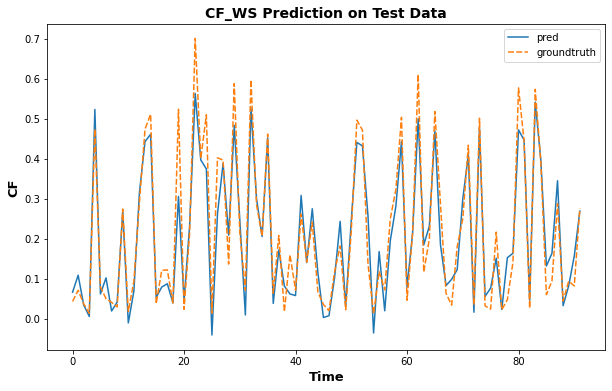

In [15]:
from sklearn import datasets, ensemble

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


## gradientBoostingRegressor

params = {
    "max_depth": 4,
    "random_state": 0,
    
}

mlrf = ensemble.RandomForestRegressor(**params)
## engineer new features to improve the results

sc_x = StandardScaler()

# scale and normalize training data
X_new = sc_x.fit_transform(x)

# model fitting
mlr.fit(X_new, y)

# prediction
X_val_new = sc_x.transform(x_val)
y_hat = mlr.predict(X_val_new)
y_hat = y_hat.reshape(y_hat.shape[0],-1)
print(f'Training accu: {mlr.score(X_new, y)}')
print(f'Test accu: {mlr.score(X_val_new, y_val)}')
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE: {mae:.3f}')

# steps = [
#     ('scalar', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('model', ensemble.RandomForestRegressor(**params))
# ]

# rf_pipeline = Pipeline(steps)
# y = y.reshape(y.shape[0])
# rf_pipeline.fit(x, y)
# print(f'Train : {rf_pipeline.score(x, y)}')
# print(f'Val: {rf_pipeline.score(x_val, y_val)}')

# # prediction

# y_hat = rf_pipeline.predict(x_val)
# mae = mean_absolute_error(y_val, y_hat)

# #visualize predication 
# fig, ax = plt.subplots()
# y_hat = y_hat.reshape(y_hat.shape[0],-1)
# print(y_hat.shape)
# print(y_val.shape)
# results = np.concatenate((y_hat, y_val), axis=1)
# df_res = pd.DataFrame(results, columns=["pred", "groundtruth"])           
# sns.lineplot(data=df_res)

# # output MAE
# print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
# print(f'validation data MAE: {mae:.3f}')

#### GradientBoosting Regression provides better results compared to naive linear regression but not better than Linear Regression+L2 regularization

/Users/steven/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training accu: 0.9511689379843692
Test accu: 0.948851298032892
validation data MAE from sklearn mae metrics: 0.033
validation data MAE: 0.033


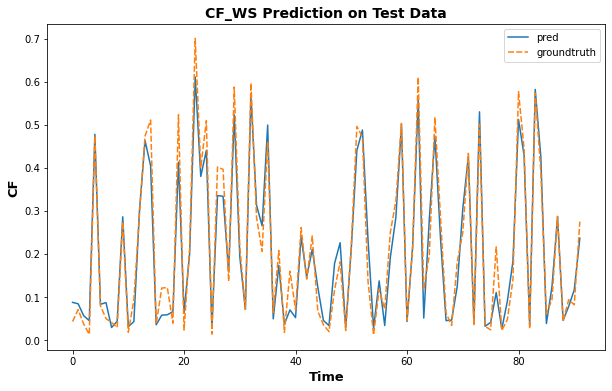

In [18]:
from sklearn import datasets, ensemble

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


## gradientBoostingRegressor

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

mlr = ensemble.GradientBoostingRegressor(**params)
## engineer new features to improve the results

sc_x = StandardScaler()

# scale and normalize training data
X_new = sc_x.fit_transform(x)

# model fitting
mlr.fit(X_new, y)

# prediction
X_val_new = sc_x.transform(x_val)
y_hat = mlr.predict(X_val_new)
y_hat = y_hat.reshape(y_hat.shape[0],-1)
print(f'Training accu: {mlr.score(X_new, y)}')
print(f'Test accu: {mlr.score(X_val_new, y_val)}')
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["pred", "groundtruth"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE: {mae:.3f}')


# steps = [
#     ('scalar', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('model', ensemble.GradientBoostingRegressor(**params))
# ]

# xgboost_pipeline = Pipeline(steps)
# y = y.reshape(y.shape[0])
# xgboost_pipeline.fit(x, y)
# print(f'Training accu: {xgboost_pipeline.score(x, y)}')
# print(f'Test accu: {xgboost_pipeline.score(x_val, y_val)}')

# # prediction

# y_hat = xgboost_pipeline.predict(x_val)
# mae = mean_absolute_error(y_val, y_hat)

# #visualize predication 
# fig, ax = plt.subplots()
# y_hat = y_hat.reshape(y_hat.shape[0],-1)
# print(y_hat.shape)
# print(y_val.shape)
# results = np.concatenate((y_hat, y_val), axis=1)
# df_res = pd.DataFrame(results, columns=["pred", "groundtruth"])           
# sns.lineplot(data=df_res)

# # output MAE
# print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
# print(f'validation data MAE: {mae:.3f}')

#### XGBoost Regressor provides the best results with MAE 0.027

[17:47:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Training accu: 0.9990448749940556
Test accu: 0.9534738638732089
validation data MAE from sklearn mae metrics: 0.029
validation data MAE: 0.029


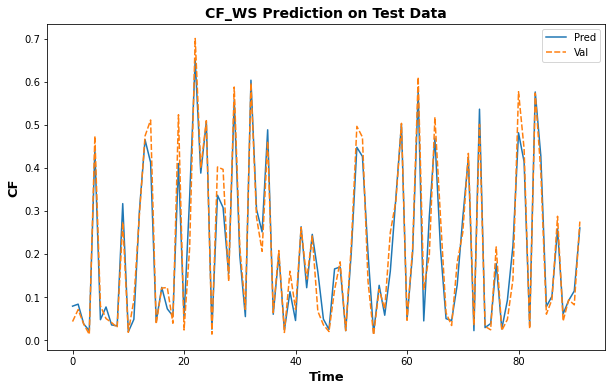

In [30]:
import xgboost as xgb

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


## XGBoostRegressor

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

## engineer new features to improve the results

sc_x = StandardScaler()

# scale and normalize training data
X_new = sc_x.fit_transform(x)

# model fitting
xgb_model.fit(X_new, y)

# prediction
X_val_new = sc_x.transform(x_val)
y_hat = xgb_model.predict(X_val_new)
y_hat = y_hat.reshape(y_hat.shape[0],-1)
print(f'Training accu: {xgb_model.score(X_new, y)}')
print(f'Test accu: {xgb_model.score(X_val_new, y_val)}')
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["Pred", "Val"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE: {mae:.3f}')

# steps = [
#     ('scalar', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('model',xgb.XGBRegressor(objective="reg:linear", random_state=42))
# ]

# rf_pipeline = Pipeline(steps)
# y = y.reshape(y.shape[0])
# rf_pipeline.fit(x, y)
# print(f'Train : {rf_pipeline.score(x, y)}')
# print(f'Val: {rf_pipeline.score(x_val, y_val)}')

# # prediction

# y_hat = rf_pipeline.predict(x_val)
# mae = mean_absolute_error(y_val, y_hat)

# #visualize predication 
# fig, ax = plt.subplots()
# y_hat = y_hat.reshape(y_hat.shape[0],-1)
# print(y_hat.shape)
# print(y_val.shape)
# results = np.concatenate((y_hat, y_val), axis=1)
# df_res = pd.DataFrame(results, columns=["pred", "groundtruth"])           
# sns.lineplot(data=df_res)

# # output MAE
# print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
# print(f'validation data MAE: {mae:.3f}')

## Test 

### Process Test Data

In [31]:
# extract hour, day, month feature
df_test['hour'] = df_test['DATETIME'].dt.hour
df_test['month'] = df_test['DATETIME'].dt.month
df_test['day'] = df_test['DATETIME'].dt.day


# X = df_train.set_index('DATETIME')
x_test = df_test.drop(['DATETIME','CF'], axis=1)
print(x_test.head())
x_test = x_test.values

   WS_1133733  WS_1156770  WS_1156968  WS_1182195  WS_1193865  WS_1321569  \
0        1.69        1.88        3.15        0.92        2.27        1.14   
1        1.60        2.02        3.91        0.44        2.36        1.15   
2        1.79        2.14        4.20        0.65        2.06        1.28   
3        2.01        2.32        5.17        0.51        2.31        0.83   
4        2.12        2.54        4.19        0.77        4.52        0.97   

   WS_1324653  WS_1358699  WS_1366338  WS_1366351  ...  WS_875373  WS_883683  \
0        1.24        2.98        2.53        2.18  ...       1.43       1.28   
1        1.63        2.83        2.84        2.20  ...       2.04       1.60   
2        2.36        3.07        2.34        1.94  ...       2.91       1.81   
3        3.39        3.38        2.53        2.26  ...       2.49       2.09   
4        2.89        3.79        4.21        4.46  ...       1.36       2.08   

   WS_883699  WS_914573  WS_918665  WS_920775  WS_921049

### Train a Model with all the data and Run Test

[17:49:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
final prediction:[[0.01118319]
 [0.01360354]
 [0.01976289]
 [0.03398265]
 [0.02333093]
 [0.03238746]
 [0.06812375]
 [0.11983749]
 [0.15797757]
 [0.08542921]
 [0.03926381]
 [0.04617029]
 [0.03215211]
 [0.03148091]
 [0.08992168]
 [0.16521522]
 [0.3098668 ]
 [0.3960559 ]
 [0.371119  ]
 [0.3619896 ]
 [0.37282702]
 [0.32624927]
 [0.32315147]
 [0.3277393 ]
 [0.32833713]
 [0.33960003]
 [0.3174226 ]
 [0.29852474]
 [0.33448067]
 [0.3228185 ]
 [0.24208765]
 [0.10331046]
 [0.11885667]
 [0.04884667]
 [0.06398661]
 [0.10468109]
 [0.11171347]
 [0.1340698 ]
 [0.07027994]
 [0.0660584 ]
 [0.05280492]
 [0.03272994]
 [0.04901242]
 [0.048842  ]
 [0.0348829 ]
 [0.03833416]
 [0.05060786]
 [0.03703418]
 [0.0377775 ]
 [0.04247643]
 [0.03514558]
 [0.03325025]
 [0.04082628]
 [0.04399868]


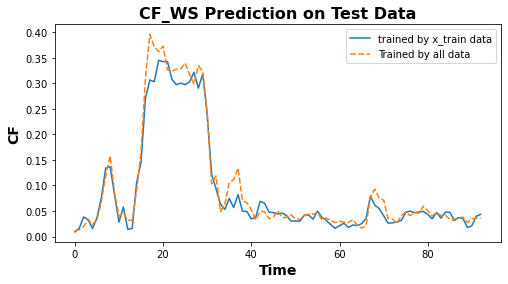

In [33]:
import xgboost as xgb

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## All data samples
# split dataset
Y = df_train[['CF']]
X = df_train.drop(['DATETIME','CF'], axis=1)
x_all, y_all = X.values, Y.values

## XGBoostRegressor
xgb_model_all = xgb.XGBRegressor(objective="reg:linear", random_state=42)

## engineer new features to improve the results

sc_x_all = StandardScaler()

# scale and normalize training data
X_new_all = sc_x_all.fit_transform(x_all)

# model fitting
xgb_model_all.fit(X_new_all, y_all)

# prediction
X_val_new_all = sc_x_all.transform(x_test)
y_hat_all = xgb_model_all.predict(X_val_new_all)
y_hat_test_all = y_hat_all.reshape(y_hat_all.shape[0],-1)

# prediction
X_test_new = sc_x.transform(x_test)
y_hat_test = xgb_model.predict(X_test_new)
y_hat_test = y_hat_test.reshape(y_hat_test.shape[0],-1)

#visualize predication 
## Prepare dataframe
results = np.concatenate((y_hat_test, y_hat_test_all), axis=1)
df_res = pd.DataFrame(results, columns=["trained by x_train data", "Trained by all data"]) 
## Set figure size
fig, ax = plt.subplots(figsize = (8,4))
## Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':16, 'fontweight':'bold'})
## Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 14, 'fontweight':'bold'})
## Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 14, 'fontweight':'bold'})
# print(f'final prediction:{y_hat_test_all}')

In [ ]:
###data split

In [ ]:
# import numpy as np
# from sklearn.model_selection import train_test_split


# Y = df_train[['CF']].to_numpy()
# X = df_train.drop(['DATETIME','CF'], axis=1).to_numpy()

# # X_train, X_val, y_train, y_val = X[:int(len(data) * 0.75)], X[int(len(data) * 0.75):]
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.05, shuffle=False)
# # X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.05, random_state=42)
# print(f'X_train:{X_train.shape};X_val:{X_val.shape};y_train:{y_train.shape};y_val:{y_val.shape}')
# y_test,X_test = df_test['CF'].to_numpy(), df_test.drop(['DATETIME','CF'], axis=1).to_numpy()
# print(f'X_test:{X_test.shape};y_test:{y_test.shape}')

In [ ]:
# ### Import Packages ###

# import itertools
# import statsmodels.api as sm
# import pandas as pd

# ### Define Parameter Ranges to Test ###

# # Note: higher numbers will result in code taking much longer to run
# # Here we have it set to test p,d,q each = 0, 1 & 2

# # Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
# p = d = q = range(0, 3)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, q and q triplets
# # Note: here we have 12 in the 's' posit6ion as we have monthly data
# # You'll want to change this according to your time series' frequency
# pdqs = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]

# # df_train['DATETIME'] = pd.to_datetime(df_train['DATETIME'], format="%d/%m/%Y")

# train, val = df_train[:-32], df_train[-32:]
# print(f'train data:{train.shape}, val data:{val.shape}')
# ### Run Grid Search ###

# # Note: this code will take a while to run

# # Define function
# def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
#     '''
#     Input: 
#         ts : your time series data
#         pdq : ARIMA combinations from above
#         pdqs : seasonal ARIMA combinations from above
#         maxiter : number of iterations, increase if your model isn't converging
#         frequency : default='M' for month. Change to suit your time series frequency
#             e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
#     Return:
#         Prints out top 5 parameter combinations
#         Returns dataframe of parameter combinations ranked by BIC
#     '''
#     print(sm.tsa.statespace.SARIMAX)
#     # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
#     ans = []
#     for comb in pdq:
#         for combs in pdqs:
# #             try:
#             mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
#                                             order=comb,
#                                             seasonal_order=combs,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False,)
# #                                             freq=freq)

#             output = mod.fit(maxiter=maxiter) 
#             ans.append([comb, combs, output.bic])
#             print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
# #             except:
# #                 continue
            
#     # Find the parameters with minimal BIC value
#     print(ans)
#     # Convert into dataframe
#     ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

#     # Sort and return top 5 combinations
#     ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
#     return ans_df
    
# ### Apply function to your time series data ###

# # Remember to change frequency to match your time series data
# # df_ans = sarimax_gridsearch(train['CF'], pdq, pdqs, freq='H')

# # print(df_ans.head())